# Pima Indians diabetes mellitus classification based on machine learning (ML) algorithms

In [14]:
# TODO add the explanation of the dataset and what is the paper's purpose

## 1. Data preparation and visualization

### Import all necessary dependencies

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, anderson
import statsmodels.api as sm

### Load the dataset

In [73]:
diabetes = pd.read_csv("data/diabetes.csv")

### Start the initial data exploration

In [74]:
# We have 768 data points with 8 independent and 1 dependent variable
diabetes.shape

(768, 9)

In [75]:
# Take a look what are we dealing with
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [76]:
# Get info about non-null values and data types.
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can see that there are no categorical variables, the dataset contains only **combination of discrete (BMI and DiabetesPedigreeFunction) and continuous variables (the rest)**.
This makes our life a little bit easier because we don't have to think about **categorical variables** and converting it to the numerical value with e.g **label encoding or one hot encoding**.
Also great thing is that the dataset contains all data, there are **no null or missing values**.

### Descriptive statistics

In [77]:
# First glance at some basic statistical info
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


More or less, from the columns values it can be easily concluded what which feature represents but let's make it clear so we remove any possible confusion:
- **Pregnancies** -> number of pregnancies.
- **Glucose** -> Plasma glucose concentration at 2 hours in an oral glucose tolearance test (GTIT).
- **BloodPressure** -> Diastolic Blood Pressure (mm Hg).
- **SkinThickness** -> Triceeps skin fold thickness (mm).
- **Insulin** -> 2-Hour Serum insulin (uh/ml).
- **BMI** -> Body mass index (weight in kg/height in m).
- **DiabetesPedigreeFunction** -> A function that scores the likelihood of diabetes based on family history.
- **Age** -> Age (years).
- **Outcome** -> Binary value indicating non-diabetic/diabetic.


In [78]:
# Take a look if there are some candidates for some monotonic attributes
diabetes.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

It seems that there are **no monotonic attributes**. If we think more about values and what they represent, this makes perfectly sense. 
Before diving deeper into visualizing data, let's make sure that all data we have are correct and have some meaning. From the domain experts, it is known that for neither of the features zero values should be present in the dataset and hence, if such exist, can be considered inconsistent. However, from the output of the `describe()` method we see that zero values exist for the **glucose concentration, blood pressure, insulin, BMI and skin fold thickness data**. Let's take a look with how many such examples we are dealing with.

In [79]:
print("Blood pressure is invalid in:", (diabetes.BloodPressure == 0).sum(), "examples. ")
print("Glucose concentration is invalid in:", (diabetes.Glucose == 0).sum(), "examples. ")
print("Insulin is invalid in:", (diabetes.Insulin == 0).sum(), "examples. ")
print("BMI is invalid in:", (diabetes.BMI == 0).sum(), "examples. ")
print("Skin fold thickness is invalid in:", (diabetes.SkinThickness == 0).sum(), "examples. ")

print("----------")
print("In", ((diabetes.BloodPressure == 0) | (diabetes.Glucose == 0) | (diabetes.Insulin == 0) | (diabetes.BMI == 0) | (diabetes.SkinThickness == 0)).sum(), "examples, there is at least one feature invalid. " )

Blood pressure is invalid in: 35 examples. 
Glucose concentration is invalid in: 5 examples. 
Insulin is invalid in: 374 examples. 
BMI is invalid in: 11 examples. 
Skin fold thickness is invalid in: 227 examples. 
----------
In 376 examples, there is at least one feature invalid. 


This means that 0.4896% examples contain some feature invalid which is quite a lot. Because of that, let's **impute the median value on the features that had invalid zero values**.

### Impute the median value

In [80]:
# Change all zero values with the median values
diabetes_med = diabetes.copy()
diabetes_med.loc[diabetes.BloodPressure == 0, "BloodPressure"] = diabetes.loc[:, "BloodPressure"].median()
diabetes_med.loc[diabetes.Glucose == 0, "Glucose"] = diabetes.loc[:, "Glucose"].median()
diabetes_med.loc[diabetes.Insulin == 0, "Insulin"] = diabetes.loc[:, "Insulin"].median()
diabetes_med.loc[diabetes.BMI == 0, "BMI"] = diabetes.loc[:, "BMI"].median()
diabetes_med.loc[diabetes.SkinThickness == 0, "SkinThickness"] = diabetes.loc[:, "SkinThickness"].median()

Since with this procedure we will mostly disrupt insulin and skin fold thickness values, let's make sure that the distribution of each feature remained the same.

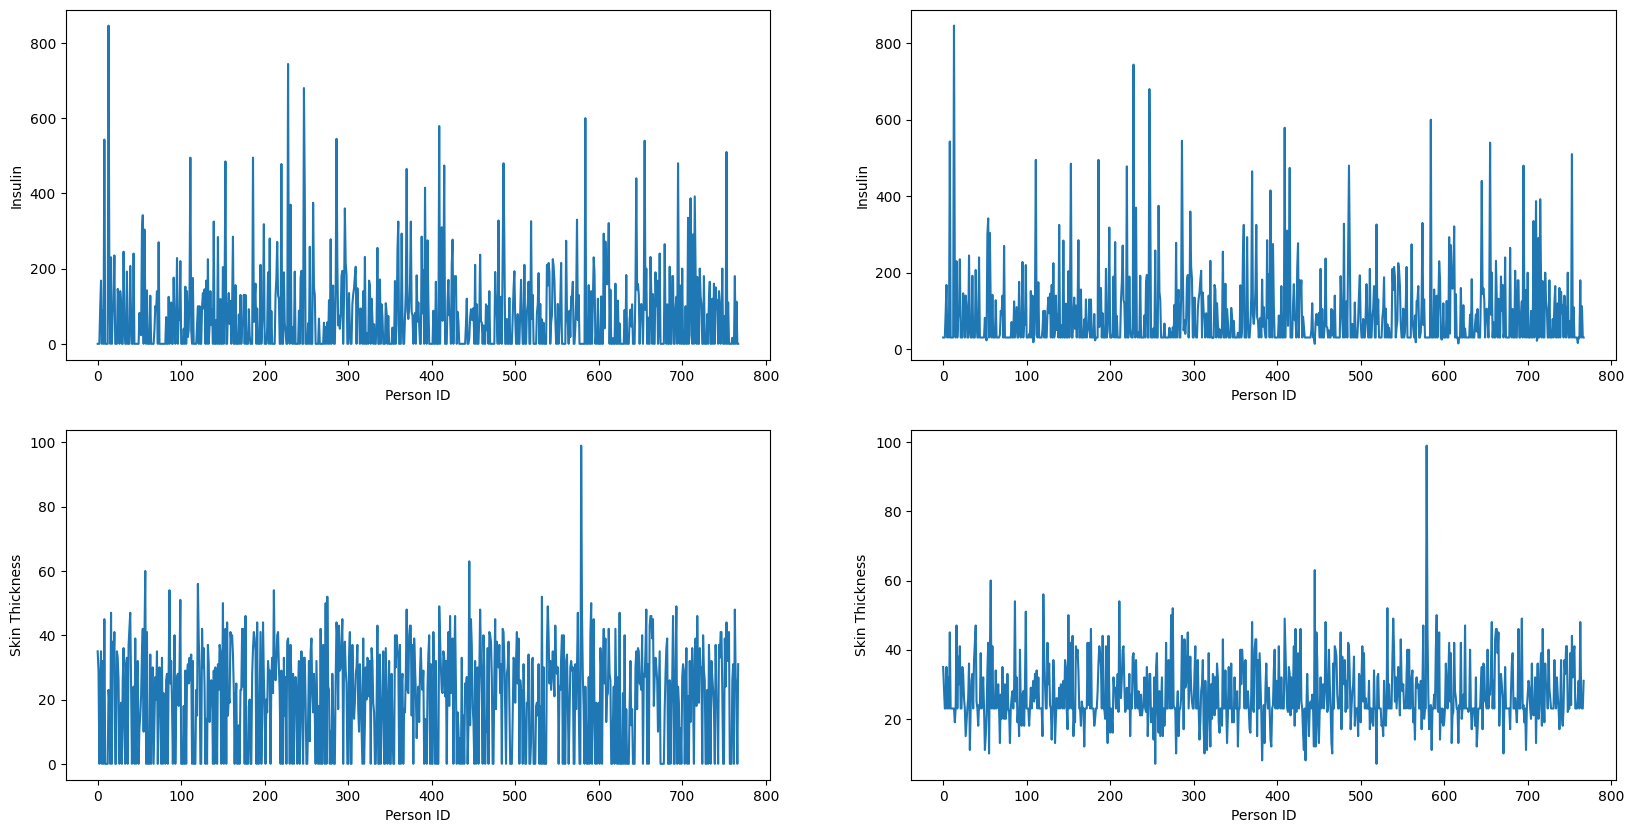

In [84]:
# First extract all values that we will use
ids = [i for i in range(768)]
blood_pressures = diabetes.BloodPressure

# define axes
fig, ax = plt.subplots(2,2, figsize=(20,10)) 

# Insulin distributions comparison
ax[0, 0].plot(ids, diabetes.Insulin)
ax[0, 0].set_xlabel("Person ID")
ax[0, 0].set_ylabel("Insulin")
ax[0, 1].plot(ids, diabetes_med.Insulin)
ax[0, 1].set_xlabel("Person ID")
ax[0, 1].set_ylabel("Insulin")

# Skin thickness distributions comparison
ax[1, 0].plot(ids, diabetes.SkinThickness)
ax[1, 0].set_xlabel("Person ID")
ax[1, 0].set_ylabel("Skin Thickness")
ax[1, 1].plot(ids, diabetes_med.SkinThickness)
ax[1, 1].set_xlabel("Person ID")
ax[1, 1].set_ylabel("Skin Thickness")

plt.show()

Although it is quite hard to estimate if the distributions are the same, let's test that out with the two sample **Kolmogorov-Smirnov test**. Our null hypothesis is that the distributions of the original values and with the imputed median values are the same for insulin and skin thickness features. 

In [ ]:
print(ks_2samp(diabetes.Insulin, diabetes_med.Insulin))
print(ks_2samp(diabetes.SkinThickness, diabetes_med.SkinThickness))

KstestResult(statistic=0.4869791666666667, pvalue=6.2289186348934944e-83)
KstestResult(statistic=0.2955729166666667, pvalue=5.52103149391426e-30)


Since the **p-value is very small**, we have sufficient evidence that two distributions for insulin and skin thickness values are not the same so we **reject the null hypothesis**. Although, this is not the ideal scenario, we **continue our survey with the same data** since we cannot afford to lose almost 50% of the data we have.

In [92]:
diabetes = diabetes_med

### Outliers

In this part we will try to deal with **outliers**. They may exist due to the **variability in the measurements or experimental errors**. One of the best methods to detect outliers is by plotting distribution with the help of the **box-plot**. We will skip age and pregnancies since those value may have their "inner bias" so concluding there are some outliers would be more guessing than finding some meaningful insights.

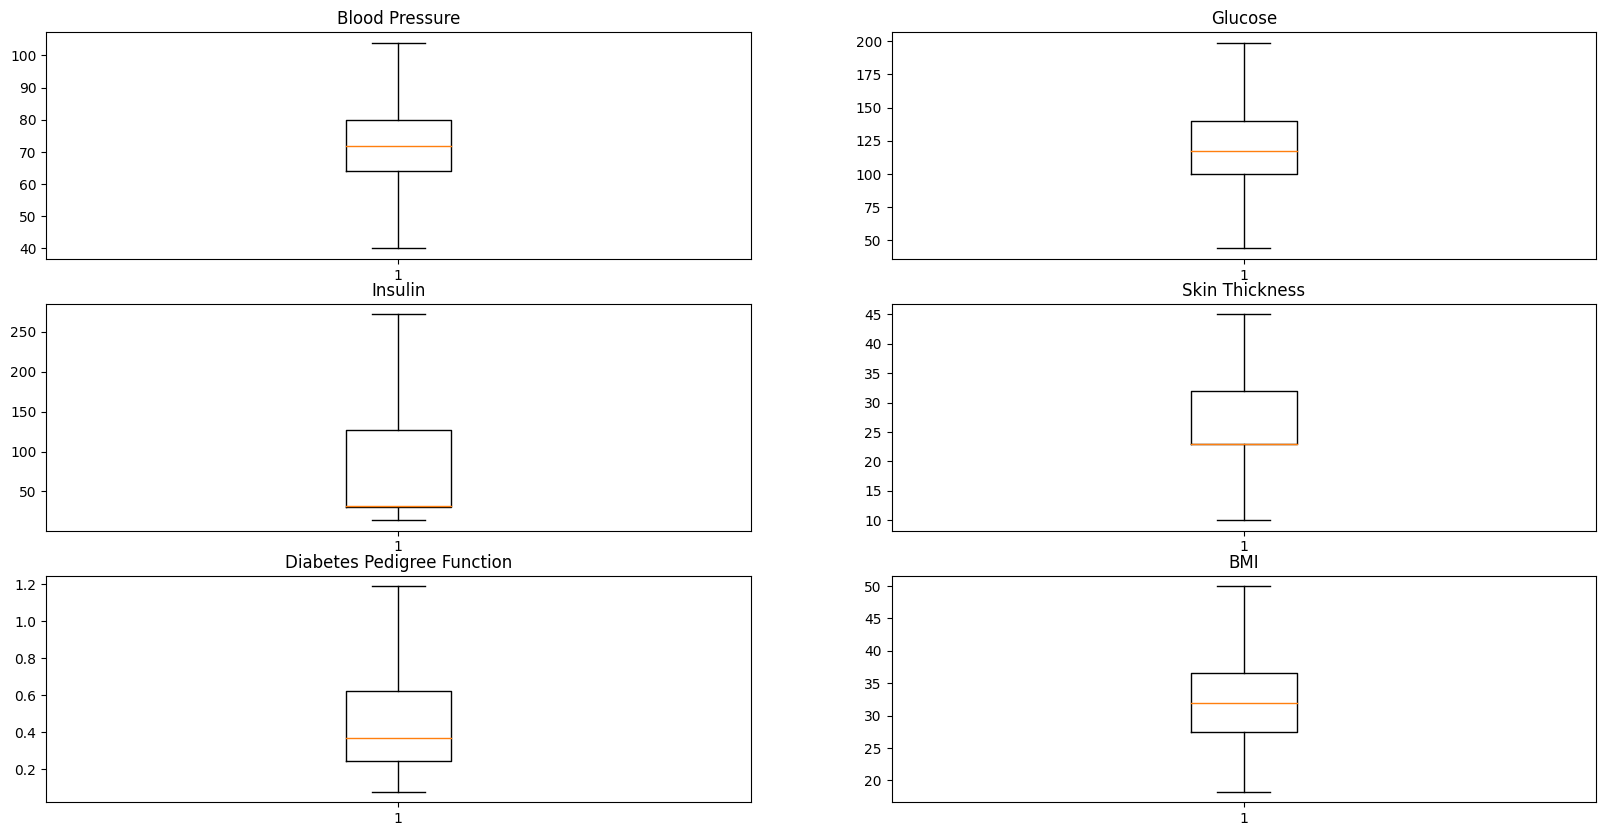

In [100]:
# define the axes
fix, ax = plt.subplots(3, 2, figsize=(20, 10))
# Blood pressure
ax[0, 0].boxplot(diabetes.BloodPressure, showfliers=False)
ax[0, 0].set_title("Blood Pressure")
# Glucose
ax[0, 1].boxplot(diabetes.Glucose, showfliers=False)
ax[0, 1].set_title("Glucose")
# Insulin
ax[1, 0].boxplot(diabetes.Insulin, showfliers=False)
ax[1, 0].set_title("Insulin")
# SkinThickness
ax[1, 1].boxplot(diabetes.SkinThickness, showfliers=False)
ax[1, 1].set_title("Skin Thickness")
# Diabetes pedigree function
ax[2, 0].boxplot(diabetes.DiabetesPedigreeFunction, showfliers=False)
ax[2, 0].set_title("Diabetes Pedigree Function")
# BMI
ax[2, 1].boxplot(diabetes.BMI, showfliers=False)
ax[2, 1].set_title("BMI")
plt.show()

Box plots may indicate that outliers exist for the insuling and diabetes pedigree function features. However, thinking about outliers for the insulin feature can be quite misleading since we imputed the median value in almost half of the examples so it is logical that the whole distribution is quite centered. Another visualization that can give us an insight if there are some outliers is the histogram.




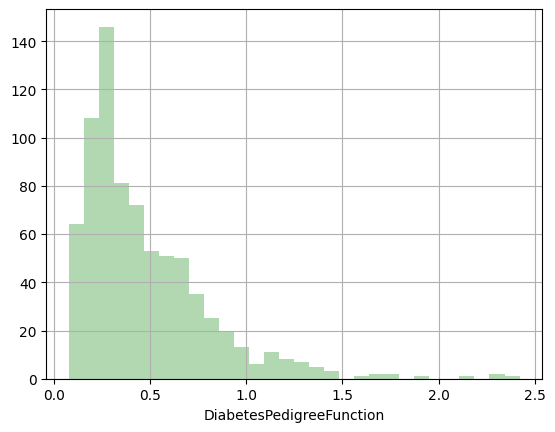

In [101]:
# Use the histogram to detect the outliers in the diabetes pedigree function
plt.hist(diabetes.DiabetesPedigreeFunction, bins=30, alpha=0.3, color="green")
plt.grid()
plt.xlabel("DiabetesPedigreeFunction")
plt.show()

Since there are some very small bins far to the right, it is possible that they represent outliers. Standardization of the data and the calculation of the z-scores can also be used for detecting the outliers. Basically we use an assumption that the data comes from the normal distribution and calculate the probability of seeing such or more extreme value. Except performing goodness-of-fit tests, QQ plot may be a good indicator of the data normality. 

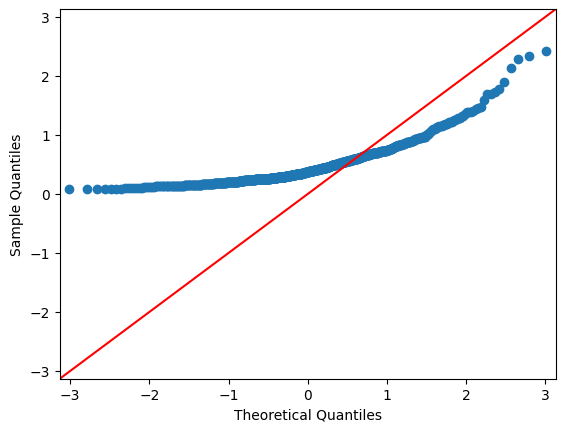

In [107]:
fig = sm.qqplot(diabetes.DiabetesPedigreeFunction, line='45')
plt.show()

QQ plot indicates that the data doesn't come from the normal distribution. Let's confirm that with the `Anderson-Darling` test with the null hypothesis that the data comes from the normal distribution.

In [104]:
anderson(diabetes.DiabetesPedigreeFunction)

AndersonResult(statistic=29.13404800507169, critical_values=array([0.573, 0.653, 0.783, 0.913, 1.086]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Since the test statistics is greater than critical values at all significance levels, we can reject null hypothesis that the data comes from the normal distribution. Unfortunately, QQ plot and `Anderson-Darling` test give us a lot of evidence to conclude that the values don't follow normal distribution. Hence, we will give up on the detecting outliers with the z-scores.

Since the author didn't take much care about outliers, we will also skip this analysis and leave it maybe for the end and possible improvements. TODO: dataset preprocessing, distribution regards target class, distribution for the training and test set split, Anderson-Darling test mathematics, pie chart for the distribution of the results scatterplot and many more visualizations....